In [96]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [97]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.image import resize
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [98]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [99]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [101]:
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [102]:
X_train = train.drop('label', axis=1).values
y_train = train['label'].values
print(type(X_train))

<class 'numpy.ndarray'>


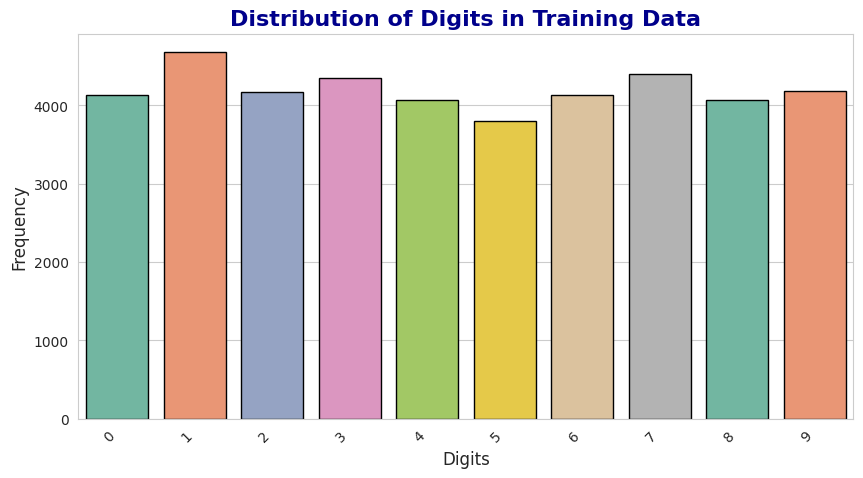

In [103]:
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")  # Set a nice background grid
sns.countplot(x=y_train, palette="Set2", edgecolor="black") # Use a color palette and edge color
plt.title("Distribution of Digits in Training Data", fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel("Digits", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.show()

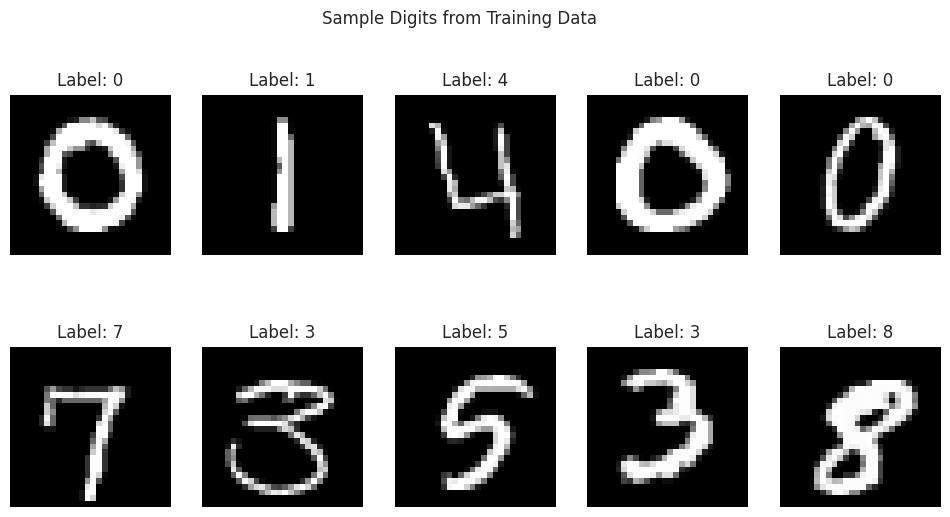

In [104]:
# Visualize some examples
def plot_samples(data, labels, title):
    plt.figure(figsize=(12, 6))
    for i in range(1, 11):
        plt.subplot(2, 5, i)
        plt.imshow(data[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

plot_samples(X_train, y_train, "Sample Digits from Training Data")

In [105]:
# Normalize and Reshape data
X_train = X_train.reshape(-1, 28, 28, 1) / 255.0
X_test = test.values / 255.0
X_test = X_test.reshape(-1, 28, 28, 1)
y_train = to_categorical(y_train)

X_train = resize(X_train, [64, 64])
X_test = resize(X_test, [64, 64])

In [106]:
# Display first few rows of reshaped data
print(f"After reshaping: Training data shape: {X_train.shape}, Labels: {y_train.shape}")

After reshaping: Training data shape: (42000, 64, 64, 1), Labels: (42000, 10)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


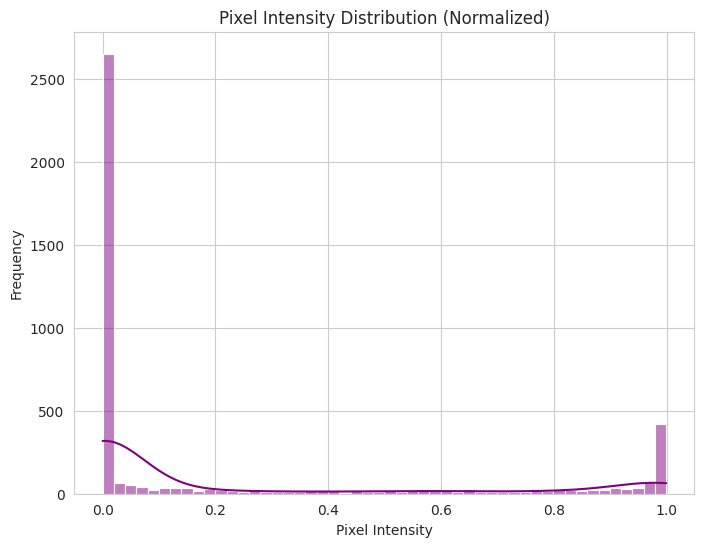

In [107]:
# Check pixel intensity distribution
tf.experimental.numpy.experimental_enable_numpy_behavior()
plt.figure(figsize=(8, 6))
sns.histplot(X_train[1].ravel(), bins=50, color="purple", kde=True)
plt.title("Pixel Intensity Distribution (Normalized)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

In [108]:
model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='valid'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.35),

    # Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    GlobalAveragePooling2D(),
    Dropout(0.5),

    # Fully Connected
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [109]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 26, 26, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 5, 5, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,922 (1.23 MB)

 Trainable params: 322,474 (1.23 MB)

 Non-trainable params: 448 (1.75 KB)

In [110]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [111]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                              restore_best_weights=True)

In [113]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9879 - loss: 0.0441 - val_accuracy: 0.9924 - val_loss: 0.0271
Epoch 2/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9898 - loss: 0.0367 - val_accuracy: 0.9924 - val_loss: 0.0251
Epoch 3/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9902 - loss: 0.0344 - val_accuracy: 0.9917 - val_loss: 0.0291
Epoch 4/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9912 - loss: 0.0319 - val_accuracy: 0.9931 - val_loss: 0.0226
Epoch 5/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9899 - loss: 0.0354 - val_accuracy: 0.9895 - val_loss: 0.0304
Epoch 6/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9905 - loss: 0.0316 - val_accuracy: 0.9938 - val_loss: 0.0230
Epoch 7/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9899 - loss: 0.0362 - val_accuracy: 0.9936 - val_loss: 0.0208
Epoch 8/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9914 - loss: 0.0303 - 

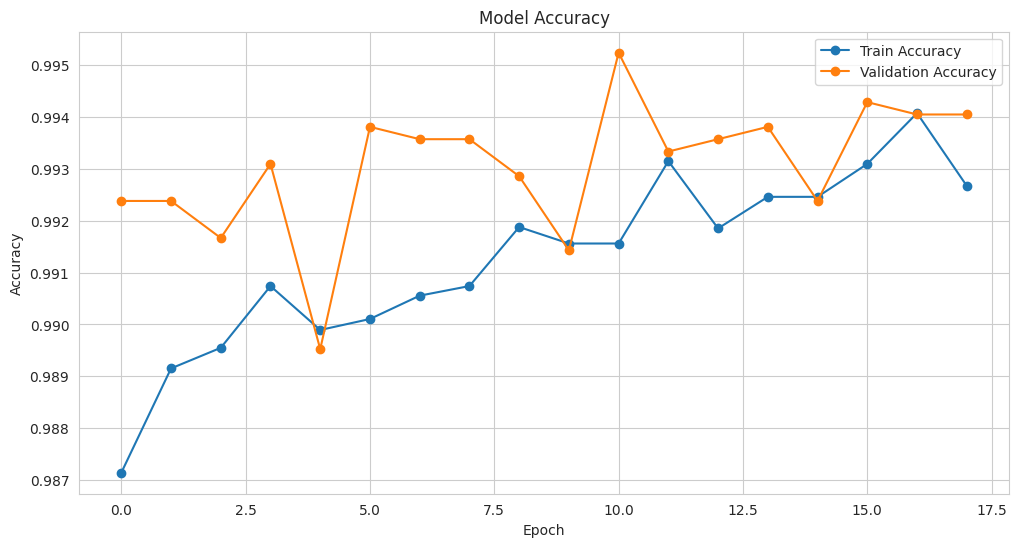

In [115]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

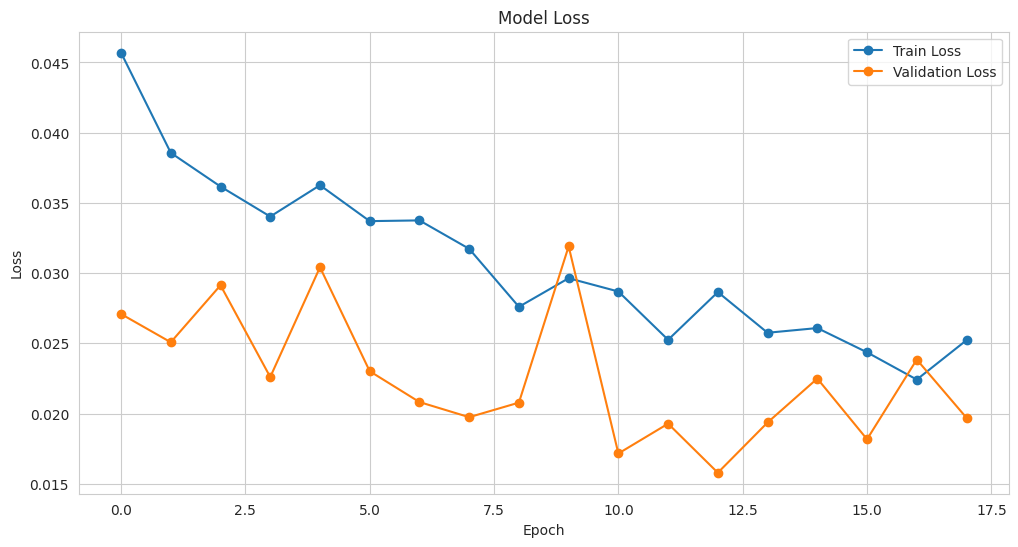

In [119]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [123]:
# Evaluate the model
loss, acc = model.evaluate(X_train[:50], y_train[:50], verbose=1)
print(f"Accuracy: {acc:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.3944e-05 
Accuracy: 1.00


In [124]:
predictions = np.argmax(model.predict(X_test), axis=1)

submission = pd.DataFrame({'ImageId': range(1, len(predictions) + 1), 'Label': predictions})
submission.to_csv('submission.csv', index=False)

print("Submission file saved as 'submission.csv'")

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Submission file saved as 'submission.csv'
